# Analysis of N-gram Regression Model Results

### 1. Import Libraries and Configuration

First, we import all the necessary libraries for data manipulation, loading artefacts, and plotting. We also import the project's configuration file to access global variables like file paths and column names.

### 1.1. Select Model Type
Specify which model's results you want to analyze: 'ridge' or 'gbr'.

In [1]:
# Set this to 'ridge' or 'gbr' to analyze the corresponding model's results
MODEL_TYPE_TO_ANALYZE = 'ridge'

## 1.2. Hyperparameter Search (Optional)

This section demonstrates how to use the new hyperparameter search feature. The search optimizes:
- **alpha**: Ridge regression regularization strength
- **ngram_max**: Maximum n-gram size for character-level TF-IDF
- **vocab_size**: Total vocabulary size (split between VH and VL sequences)

The search uses Bayesian optimization (scikit-optimize) to maximize the average Spearman correlation across all targets and CV folds.

**Note**: A full search with `--n-iter 50` can take hours. For demonstration purposes, use a smaller value like `--n-iter 5`.

In [ ]:
# Run hyperparameter search (uncomment to run - can be slow!)
# Adjust --n-iter based on your compute budget (5-10 for demo, 50+ for production)

# !python -m src.models.hyperparameter_search --n-iter 5

### 1.2.1. Load and Visualize Hyperparameter Search Results

If you've run the hyperparameter search (or it was run previously), you can load the results and visualize the optimization trajectory.

In [2]:
import json
from pathlib import Path

# Load best parameters if available
best_params_path = Path('artefacts/best_params.json')
search_results_path = Path('hyperparameter_search_results.csv')

if best_params_path.exists():
    with open(best_params_path, 'r') as f:
        best_params = json.load(f)
    
    print("=" * 60)
    print("BEST HYPERPARAMETERS FOUND:")
    print("=" * 60)
    print(f"Alpha (regularization):  {best_params['alpha']:.3e}")
    print(f"N-gram max:              {best_params['ngram_max']}")
    print(f"Vocabulary size:         {best_params['vocab_size']}")
    print(f"Best objective:          {best_params['best_objective']:.6f}")
    print(f"Best mean Spearman:      {-best_params['best_objective']:.6f}")
    print("=" * 60)
else:
    print("No hyperparameter search results found.")
    print("Run the search first or use default parameters from config.py")

BEST HYPERPARAMETERS FOUND:
Alpha (regularization):  6.209e-02
N-gram max:              1
Vocabulary size:         27160
Best objective:          -0.423468
Best mean Spearman:      0.423468


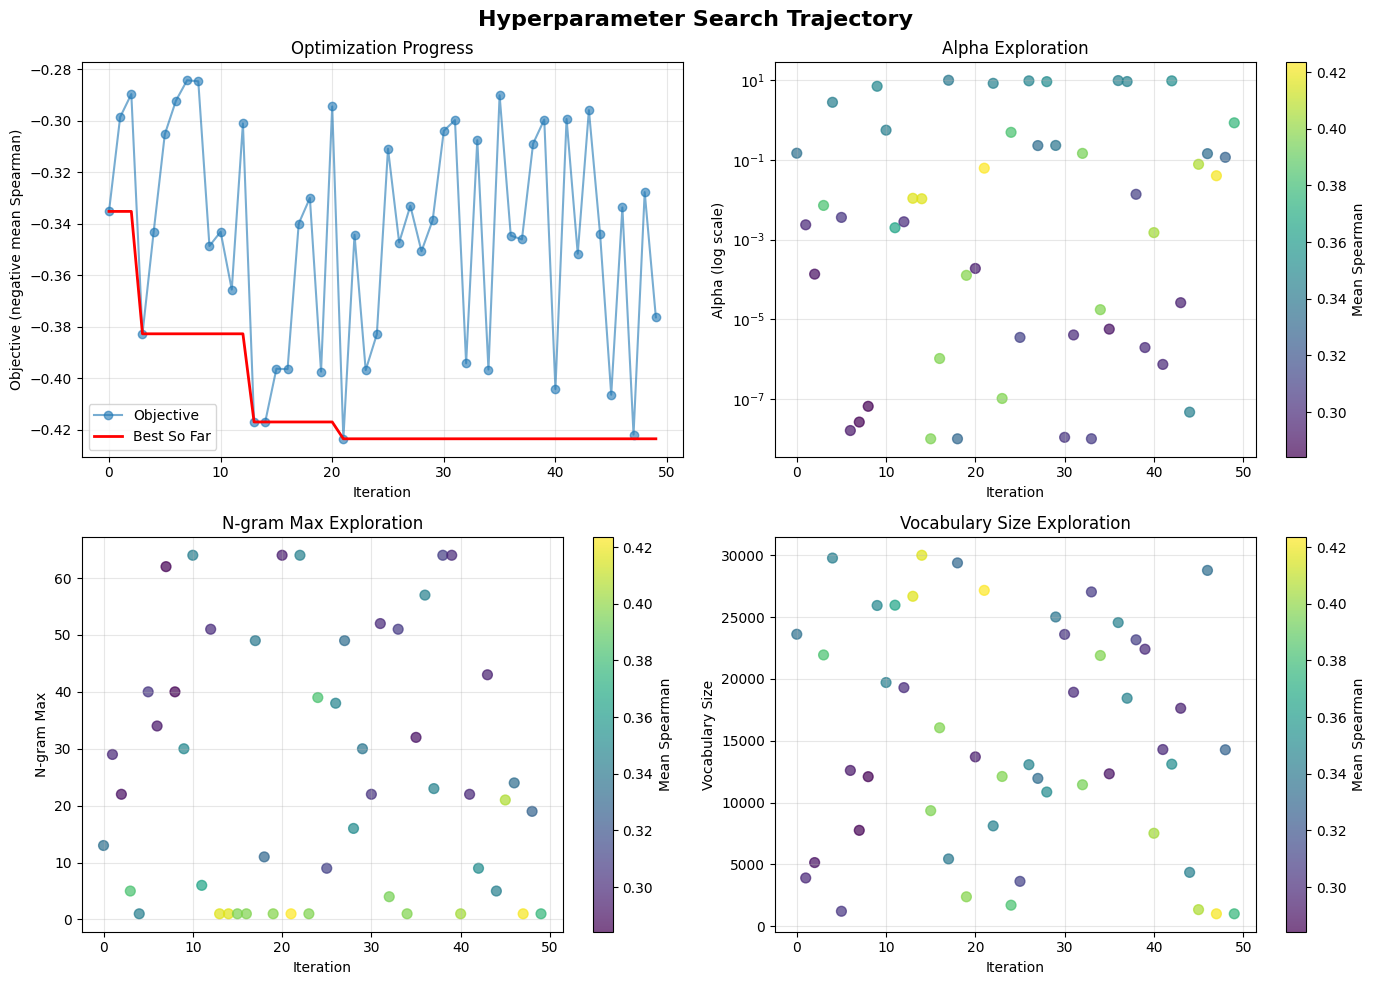


Total iterations: 50
Best iteration: 21


In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Visualize the search trajectory
if search_results_path.exists():
    search_df = pd.read_csv(search_results_path)
    
    # Create a figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle('Hyperparameter Search Trajectory', fontsize=16, fontweight='bold')
    
    # Plot 1: Objective value over iterations
    ax1 = axes[0, 0]
    ax1.plot(search_df.index, search_df['objective_value'], 'o-', alpha=0.6, label='Objective')
    ax1.plot(search_df.index, search_df['objective_value'].cummin(), 'r-', linewidth=2, label='Best So Far')
    ax1.set_xlabel('Iteration')
    ax1.set_ylabel('Objective (negative mean Spearman)')
    ax1.set_title('Optimization Progress')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Alpha exploration
    ax2 = axes[0, 1]
    scatter = ax2.scatter(search_df.index, search_df['alpha'], 
                         c=-search_df['objective_value'], cmap='viridis', alpha=0.7, s=50)
    ax2.set_xlabel('Iteration')
    ax2.set_ylabel('Alpha (log scale)')
    ax2.set_yscale('log')
    ax2.set_title('Alpha Exploration')
    ax2.grid(True, alpha=0.3)
    plt.colorbar(scatter, ax=ax2, label='Mean Spearman')
    
    # Plot 3: N-gram max exploration
    ax3 = axes[1, 0]
    scatter = ax3.scatter(search_df.index, search_df['ngram_max'], 
                         c=-search_df['objective_value'], cmap='viridis', alpha=0.7, s=50)
    ax3.set_xlabel('Iteration')
    ax3.set_ylabel('N-gram Max')
    ax3.set_title('N-gram Max Exploration')
    ax3.grid(True, alpha=0.3)
    plt.colorbar(scatter, ax=ax3, label='Mean Spearman')
    
    # Plot 4: Vocabulary size exploration
    ax4 = axes[1, 1]
    scatter = ax4.scatter(search_df.index, search_df['vocab_size'], 
                         c=-search_df['objective_value'], cmap='viridis', alpha=0.7, s=50)
    ax4.set_xlabel('Iteration')
    ax4.set_ylabel('Vocabulary Size')
    ax4.set_title('Vocabulary Size Exploration')
    ax4.grid(True, alpha=0.3)
    plt.colorbar(scatter, ax=ax4, label='Mean Spearman')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nTotal iterations: {len(search_df)}")
    print(f"Best iteration: {search_df['objective_value'].idxmin()}")
else:
    print("Search results CSV not found. Run hyperparameter search first.")

### 1.2.2. Rebuild Features with Tuned Hyperparameters

After finding the best hyperparameters, we need to rebuild the feature transformers (vectorizers) with the optimized `ngram_max` and `vocab_size`. This will update the saved transformers in `artefacts/`.

In [ ]:
# Rebuild features with tuned hyperparameters (uncomment to run)
# This will overwrite the existing vectorizers in artefacts/

# !python -m src.features.build_features --use-best

### 1.2.3. Retrain Models with Optimized Features

After rebuilding the features, retrain the Ridge models to use the tuned `alpha` parameter along with the optimized feature extraction settings. The training script will automatically use the tuned alpha from `best_params.json`.

In [ ]:
# Retrain Ridge models with tuned hyperparameters (uncomment to run)
# By default, train_model.py will use the alpha from best_params.json

# !python -m src.models.train_model --model-type ridge

---

**Pipeline Summary:**
1. Run hyperparameter search to find optimal `alpha`, `ngram_max`, and `vocab_size`
2. Rebuild features with `--use-best` flag to apply tuned n-gram and vocabulary settings
3. Retrain models (the script automatically uses tuned alpha from `best_params.json`)
4. Continue with the analysis below using the optimized models

---

In [5]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
from scipy.sparse import hstack
from scipy.stats import spearmanr
import sys
import os

# Add src to the Python path to import the config file
sys.path.append('src')
from config import (
    DATA_FILE, TARGET_PROPERTIES, FOLD_COLUMN, FOLDS, VH_SEQUENCE_COL,
    VL_SEQUENCE_COL, HC_SUBTYPE_COL, ARTEFACTS_DIR, LOG_TRANSFORM_TARGETS
)

# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')

### 2. Load Data and Transformers

Next, we load the main dataset and the pre-fitted transformers (vectorizers and one-hot encoder) that were created during the feature engineering phase. These are essential for generating the feature vectors for our test data.

In [6]:
try:
    df = pd.read_csv(DATA_FILE)
    vectorizer_vh = joblib.load(ARTEFACTS_DIR / 'vectorizer_vh.joblib')
    vectorizer_vl = joblib.load(ARTEFACTS_DIR / 'vectorizer_vl.joblib')
    encoder_ohe = joblib.load(ARTEFACTS_DIR / 'encoder_ohe.joblib')
    print("Data and transformers loaded successfully.")
except FileNotFoundError as e:
    print(f"Error: {e}. Please ensure the data and artefact files exist.")

Data and transformers loaded successfully.


### 3. Generate Predictions with Uncertainty

This is the core function for our analysis. For a given target property, it performs the following steps:
1.  Loads the corresponding trained model ensembles.
2.  Iterates through each of the 5 cross-validation folds.
3.  For each fold, it identifies the test set, transforms its features, and generates predictions using the appropriate ensemble of bootstrap models.
4.  It calculates the mean and standard deviation of the predictions from the ensemble for each data point in the test set.
5.  It collects and returns the true values, predicted means, and predicted standard deviations for all data points across all folds.

In [7]:
def get_predictions_with_uncertainty(df, target, model_type):
    """
    Generates predictions for a target property across all 5 CV folds.
    
    Args:
        df (pd.DataFrame): The full dataset.
        target (str): The name of the target property.
        model_type (str): The type of model to use ('ridge' or 'gbr').
        
    Returns:
        tuple: A tuple containing (y_true_all, y_pred_mean_all, y_pred_std_all).
    """
    try:
        model_filename = ARTEFACTS_DIR / f'models_{target}_{model_type}.joblib'
        all_fold_ensembles = joblib.load(model_filename)
        print(f"Loaded models from {model_filename}")
    except FileNotFoundError:
        print(f"Models for {target} ({model_type}) not found. Please run the training script first.")
        return None, None, None

    df_target = df.dropna(subset=[target]).copy()
    
    y_true_all = []
    y_pred_mean_all = []
    y_pred_std_all = []

    for fold_i in FOLDS:
        test_mask = (df_target[FOLD_COLUMN] == fold_i)
        df_test = df_target[test_mask]
        
        if df_test.empty:
            continue

        y_true = df_test[target].values
        
        # Transform features
        X_test_vh = vectorizer_vh.transform(df_test[VH_SEQUENCE_COL])
        X_test_vl = vectorizer_vl.transform(df_test[VL_SEQUENCE_COL])
        X_test_ohe = encoder_ohe.transform(df_test[[HC_SUBTYPE_COL]])
        X_test = hstack([X_test_vh, X_test_vl, X_test_ohe], format='csr')

        # Get the ensemble for this fold
        ensemble_models = all_fold_ensembles[fold_i]
        
        # Generate predictions from each model in the ensemble
        fold_predictions = [model.predict(X_test) for model in ensemble_models]
        
        # If target was log-transformed, convert predictions back to original scale
        if target in LOG_TRANSFORM_TARGETS:
            fold_predictions = np.expm1(fold_predictions)

        # Calculate mean and std dev across the ensemble predictions
        y_pred_mean = np.mean(fold_predictions, axis=0)
        y_pred_std = np.std(fold_predictions, axis=0)
        
        y_true_all.extend(y_true)
        y_pred_mean_all.extend(y_pred_mean)
        y_pred_std_all.extend(y_pred_std)
        
    return np.array(y_true_all), np.array(y_pred_mean_all), np.array(y_pred_std_all)

### 4. Process All Targets and Store Results

Now, we loop through all the target properties defined in our configuration. For each one, we call the function above to get the true values and predictions, and we store these results in a dictionary for later use.

In [8]:
results = {}
for target in TARGET_PROPERTIES:
    print(f"Processing {target} for model type {MODEL_TYPE_TO_ANALYZE}...")
    y_true, y_pred_mean, y_pred_std = get_predictions_with_uncertainty(df, target, MODEL_TYPE_TO_ANALYZE)
    if y_true is not None:
        results[target] = {
            'true': y_true,
            'pred_mean': y_pred_mean,
            'pred_std': y_pred_std
        }
print("All targets processed.")

Processing Titer for model type ridge...
Loaded models from /Users/kyunghyuncho/Repos/strawman-ab/artefacts/models_Titer_ridge.joblib
Processing HIC for model type ridge...
Loaded models from /Users/kyunghyuncho/Repos/strawman-ab/artefacts/models_HIC_ridge.joblib
Processing PR_CHO for model type ridge...
Loaded models from /Users/kyunghyuncho/Repos/strawman-ab/artefacts/models_PR_CHO_ridge.joblib
Processing Tm2 for model type ridge...
Loaded models from /Users/kyunghyuncho/Repos/strawman-ab/artefacts/models_Tm2_ridge.joblib
Processing AC-SINS_pH7.4 for model type ridge...
Loaded models from /Users/kyunghyuncho/Repos/strawman-ab/artefacts/models_AC-SINS_pH7.4_ridge.joblib
All targets processed.


### 5. Visualize Results: True vs. Predicted with Uncertainty

Finally, we create the scatter plots. For each target property, we plot the true values against the mean of the predicted values. The vertical error bars on each point represent the standard deviation of the predictions from the bootstrap ensemble, giving us a visual sense of the model's confidence for each prediction. We also calculate and display the Spearman rank correlation, which is our primary evaluation metric.

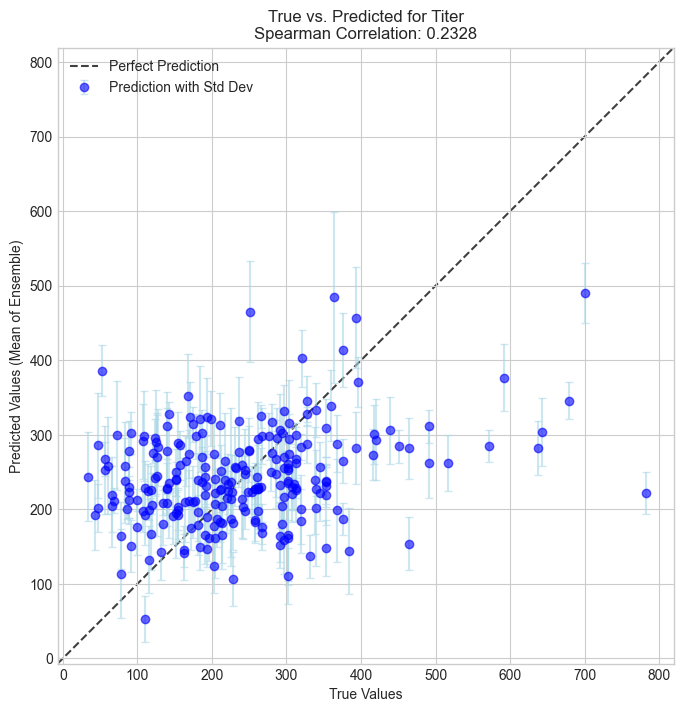

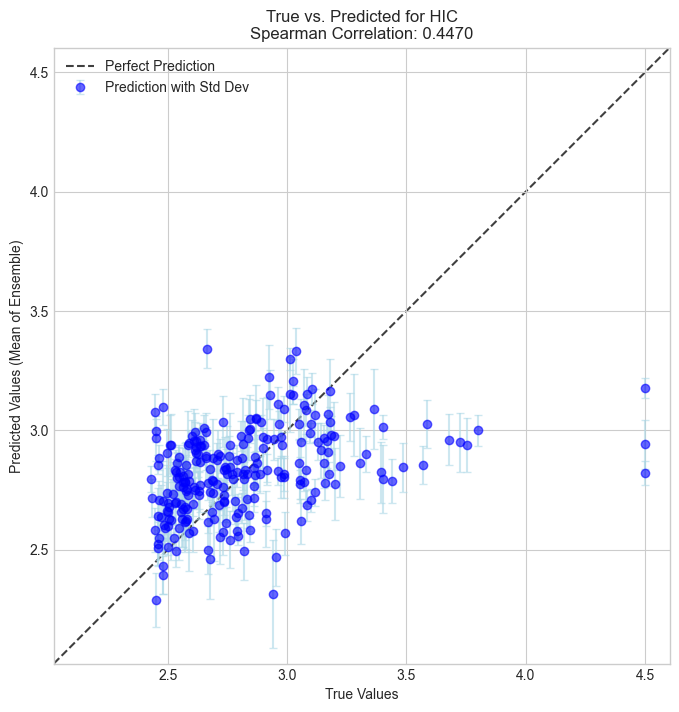

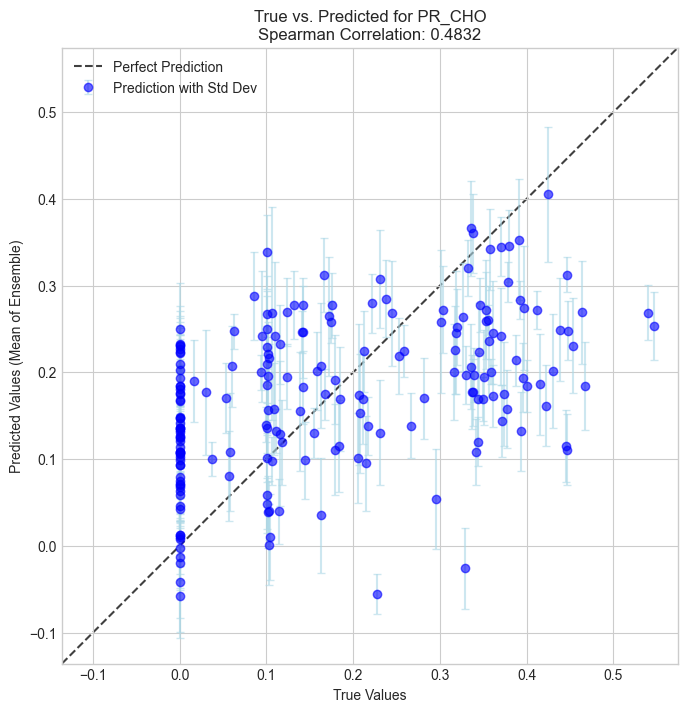

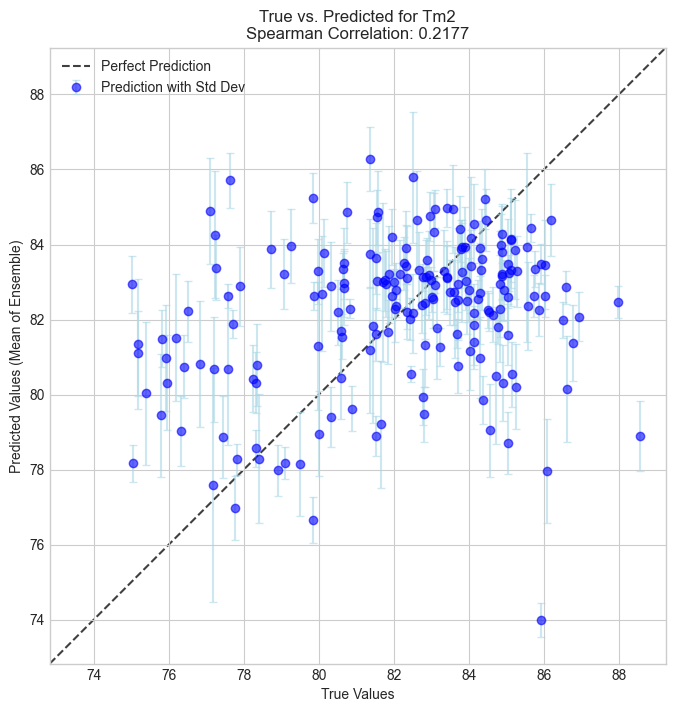

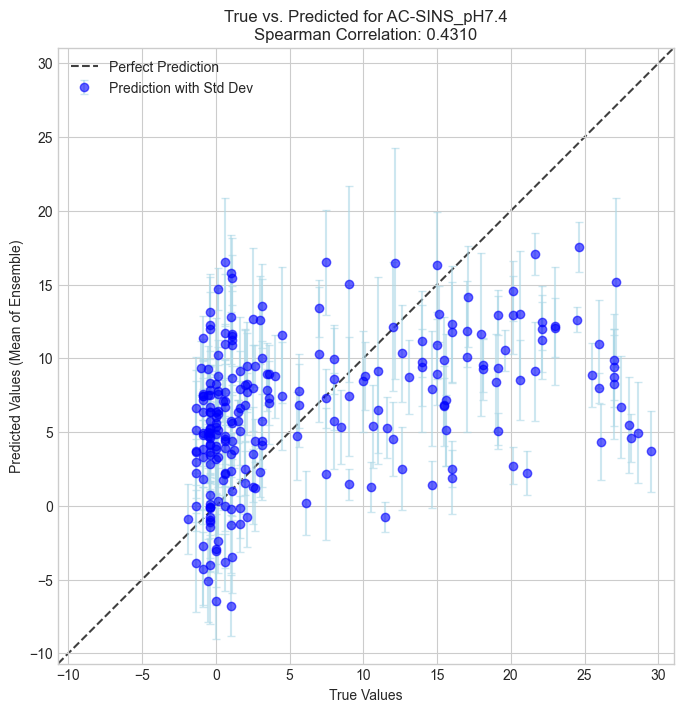

In [9]:
for target, data in results.items():
    y_true = data['true']
    y_pred_mean = data['pred_mean']
    y_pred_std = data['pred_std']
    
    # Calculate Spearman correlation
    corr, _ = spearmanr(y_true, y_pred_mean)
    
    plt.figure(figsize=(8, 8))
    
    # Create scatter plot with error bars
    plt.errorbar(y_true, y_pred_mean, yerr=y_pred_std, fmt='o', color='blue', ecolor='lightblue', capsize=3, alpha=0.6, label='Prediction with Std Dev')
    
    # Plot the 'perfect prediction' line
    lims = [
        np.min([plt.xlim(), plt.ylim()]),
        np.max([plt.xlim(), plt.ylim()]),
    ]
    plt.plot(lims, lims, 'k--', alpha=0.75, zorder=0, label='Perfect Prediction')
    plt.xlim(lims)
    plt.ylim(lims)
    
    plt.title(f'True vs. Predicted for {target}\nSpearman Correlation: {corr:.4f}')
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values (Mean of Ensemble)')
    plt.legend()
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()